In [2]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# Set up matplotlib
mpl.rcParams['figure.figsize'] = (12, 10)
# tuple where 12 is the width and 10 is the height, measured in inches.
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
# load the data
file = tf.keras.utils
raw_df = pd.read_csv(os.path.join("data", "flight_data_processed.csv"))
raw_df = raw_df[["gps_altitude_m","speed_km/s","climb_m","climb_m(delta)","climb_rate_m/s","bearing","delta_bearing","glide_ratio","elapsed_time","temp","pressure","humidity","dew_point","wind_speed","wind_deg", "zone"]]
raw_df["zone"] = raw_df["zone"].apply(lambda x: 1 if x == "thermal" else 0)
raw_df.head()

/var/folders/ss/5qhyykzn7ws047pz5bmmgw1r0000gn/T/ipykernel_6147/1355470209.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(os.path.join("data", "flight_data_processed.csv"))


,gps_altitude_m,speed_km/s,climb_m,climb_m(delta),climb_rate_m/s,bearing,delta_bearing,glide_ratio,elapsed_time,temp,pressure,humidity,dew_point,wind_speed,wind_deg,zone
0,1115,12.218615,0.0,-3.0,0.0,303,67.0,0.000000,0.0,26.69,1010.0,37.0,10.81,3.38,306.0,0
1,1115,25.606488,0.0,-3.0,0.0,270,33.0,0.000000,1.0,26.69,1010.0,37.0,10.81,3.38,306.0,0
2,1115,20.485190,0.0,-3.0,0.0,270,0.0,0.000000,2.0,26.69,1010.0,37.0,10.81,3.38,306.0,0
3,1116,25.606488,1.0,-2.0,1.0,270,0.0,7.112913,3.0,26.69,1010.0,37.0,10.81,3.38,306.0,1
4,1117,21.541278,1.0,-1.0,1.0,288,18.0,5.983688,4.0,26.69,1010.0,37.0,10.81,3.38,306.0,1


In [5]:
raw_df.describe()

,gps_altitude_m,speed_km/s,climb_m,climb_m(delta),climb_rate_m/s,bearing,delta_bearing,glide_ratio,elapsed_time,temp,pressure,humidity,dew_point,wind_speed,wind_deg,zone
count,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000
mean,2549.013677,52.049776,-0.031964,-0.632339,-0.026192,128.208505,11.336541,8.336186,16822.956221,31.048488,1006.838010,30.089995,10.966365,3.138136,229.898335,0.524154
std,621.275795,25.169579,2.587599,44.476908,1.869562,93.148811,17.172823,8.480289,9743.969272,2.945894,2.086364,7.442854,2.804663,1.262021,100.911881,0.499418
min,376.000000,0.000000,-30.000000,-383.000000,-11.000000,0.000000,0.000000,0.000000,0.000000,24.160000,1003.000000,14.000000,3.190000,0.500000,0.000000,0.000000
25%,2160.000000,41.296352,-1.000000,-26.000000,-1.000000,47.000000,2.000000,3.082997,8427.000000,28.920000,1005.000000,23.000000,9.700000,2.020000,202.000000,0.000000
50%,2551.000000,53.539497,0.000000,-1.000000,0.000000,122.000000,6.000000,7.368595,16791.000000,30.610000,1007.000000,33.000000,11.250000,3.370000,234.000000,1.000000
75%,2937.000000,63.605984,1.000000,23.000000,1.000000,184.000000,14.000000,12.795062,25154.000000,33.810000,1008.000000,36.000000,13.010000,4.220000,316.000000,1.000000
max,4403.000000,4788.987450,44.000000,1222.000000,44.000000,358.000000,180.000000,1306.481640,36656.000000,37.130000,1015.000000,42.000000,17.500000,5.510000,358.000000,1.000000


In [6]:
neg, pos = np.bincount(raw_df["zone"])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 173943
    Positive: 91173 (52.42% of total)



In [7]:
cleaned_df = raw_df.copy()

# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop("zone"))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop("zone"))
test_labels = np.array(test_df.pop("zone"))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.5249
Average class probability in validation set: 0.5230
Average class probability in test set:       0.5226


In [8]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (111323,)
Validation labels shape: (27831,)
Test labels shape: (34789,)
Training features shape: (111323, 15)
Validation features shape: (27831, 15)
Test features shape: (34789, 15)


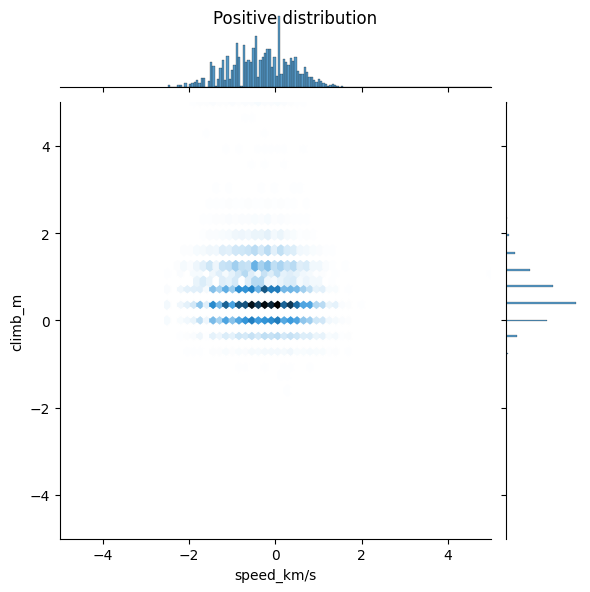

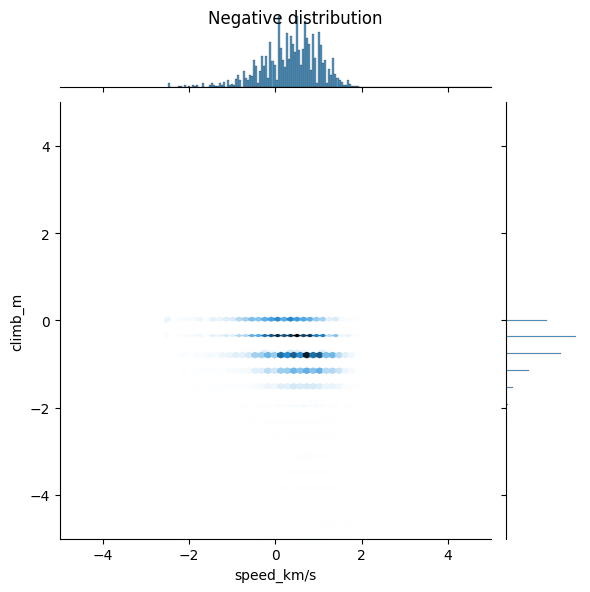

In [9]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df["speed_km/s"], y=pos_df["climb_m"],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df["speed_km/s"], y=neg_df["climb_m"],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [36]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model


EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


model = make_model()
model.summary()

/Users/serkan/Documents/Paragliding_Flight_Analyses/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 16)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273 (1.07 KB)

 Trainable params: 273 (1.07 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


array([[0.822266  ],
       [0.96031433],
       [0.89286166],
       [0.9000862 ],
       [0.82523084],
       [0.8655716 ],
       [0.6454045 ],
       [0.85974675],
       [0.80103505],
       [0.8565615 ]], dtype=float32)

In [38]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.0783


In [39]:
initial_bias = np.log([pos/neg])
initial_bias

array([0.09669312])

In [40]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


array([[0.5819149 ],
       [0.28150627],
       [0.80914766],
       [0.44886592],
       [0.6775758 ],
       [0.52061665],
       [0.67306477],
       [0.70899117],
       [0.6972984 ],
       [0.38265395]], dtype=float32)

In [41]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6281


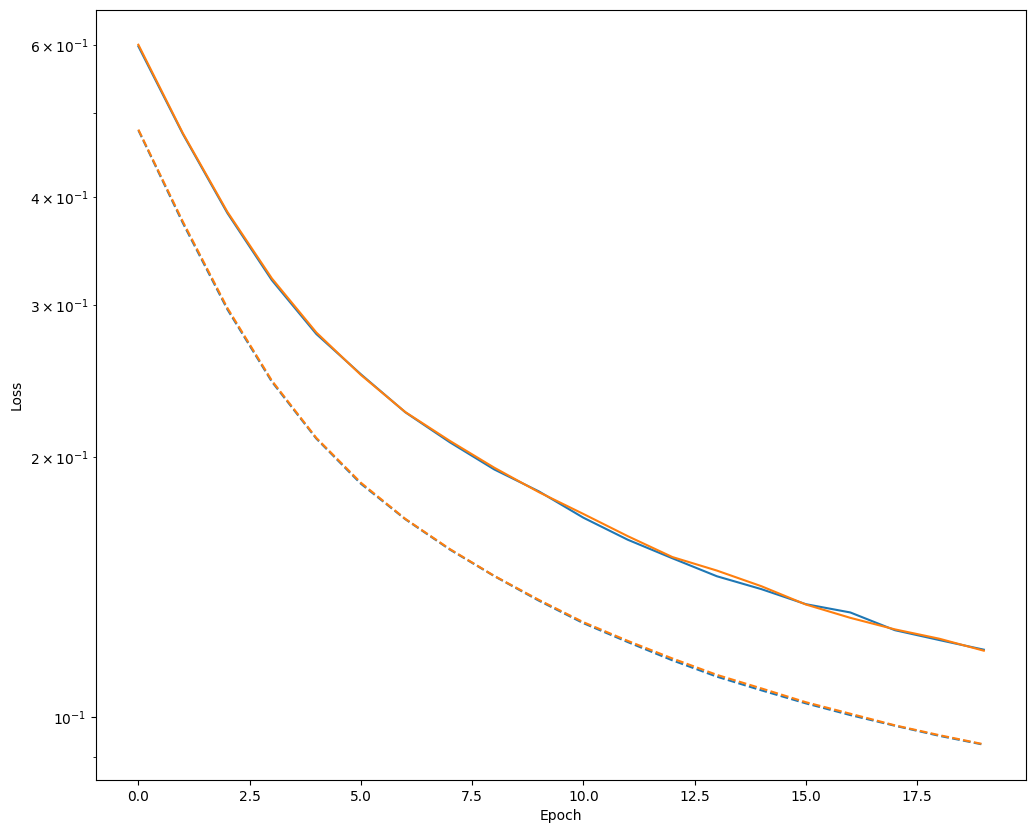

In [42]:
initial_weights = os.path.join(tempfile.mkdtemp(), "initial_weights.weights.h5")
model.save_weights(initial_weights)

model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)


model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [43]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7845 - auc: 0.8739 - fn: 8455.0361 - fp: 11550.3037 - loss: 0.6314 - prc: 0.8864 - precision: 0.7786 - recall: 0.8248 - tn: 29444.6777 - tp: 36665.3750 - val_accuracy: 0.8357 - val_auc: 0.9172 - val_fn: 1754.0000 - val_fp: 2819.0000 - val_loss: 0.4765 - val_prc: 0.9217 - val_precision: 0.8197 - val_recall: 0.8796 - val_tn: 10442.0000 - val_tp: 12816.0000
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7717 - auc: 0.8557 - fn: 5059.5356 - fp: 7844.0537 - loss: 0.4978 - prc: 0.8634 - precision: 0.7582 - recall: 0.8294 - tn: 19881.8027 - tp: 25499.0000 - val_accuracy: 0.8863 - val_auc: 0.9586 - val_fn: 1274.0000 - val_fp: 1889.0000 - val_loss: 0.3726 - val_prc: 0.9626 - val_precision: 0.8756 - val_recall: 0.9126 - val_tn: 11372.0000 - val_tp: 13296.0000
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8376 - auc: 0.9215 - fn: 3891.5356 - fp: 5406.0894 - loss: 0.3988 - prc: 0.9299 - precision:

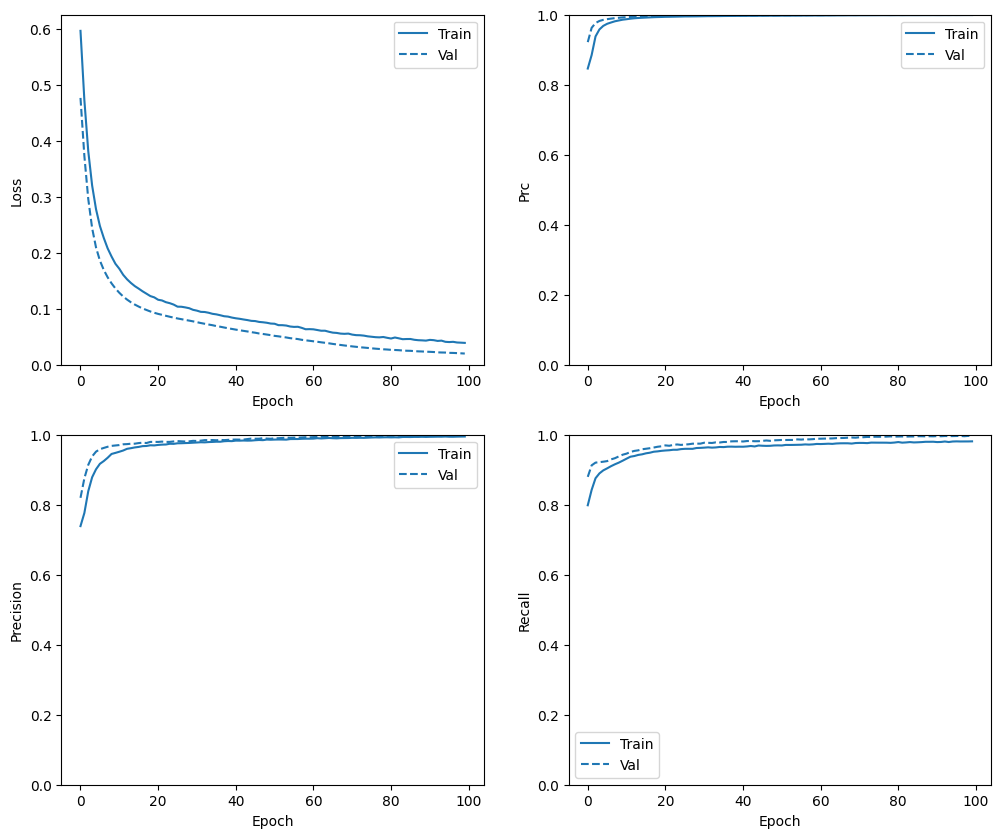

In [44]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

plot_metrics(baseline_history)

In [45]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step


loss :  0.021866099908947945
compile_metrics :  18157.0

Legitimate Transactions Detected (True Negatives):  16527
Legitimate Transactions Incorrectly Detected (False Positives):  21
Fraudulent Transactions Missed (False Negatives):  84
Fraudulent Transactions Detected (True Positives):  18157
Total Fraudulent Transactions:  18241


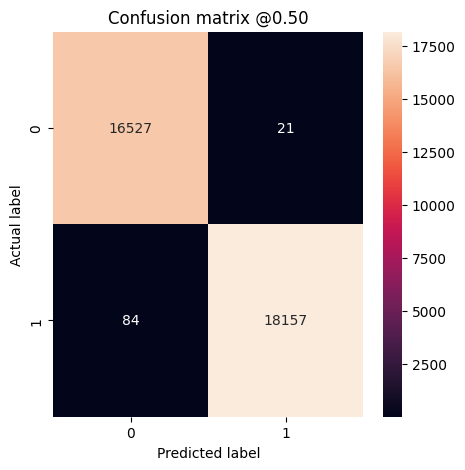

In [46]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

Legitimate Transactions Detected (True Negatives):  15695
Legitimate Transactions Incorrectly Detected (False Positives):  853
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  18228
Total Fraudulent Transactions:  18241
Legitimate Transactions Detected (True Negatives):  11954
Legitimate Transactions Incorrectly Detected (False Positives):  4594
Fraudulent Transactions Missed (False Negatives):  8
Fraudulent Transactions Detected (True Positives):  18233
Total Fraudulent Transactions:  18241


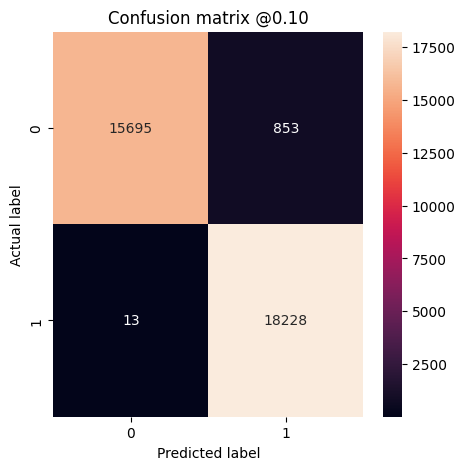

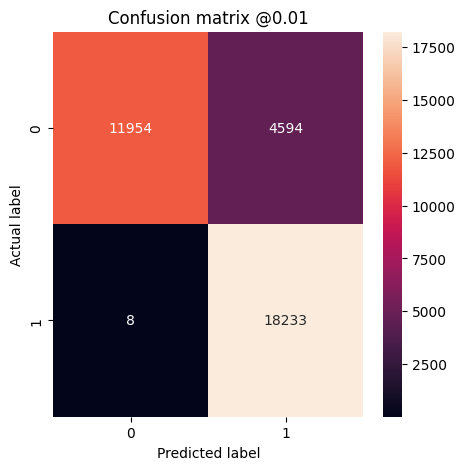

In [47]:
plot_cm(test_labels, test_predictions_baseline, 0.1)
plot_cm(test_labels, test_predictions_baseline, 0.01)

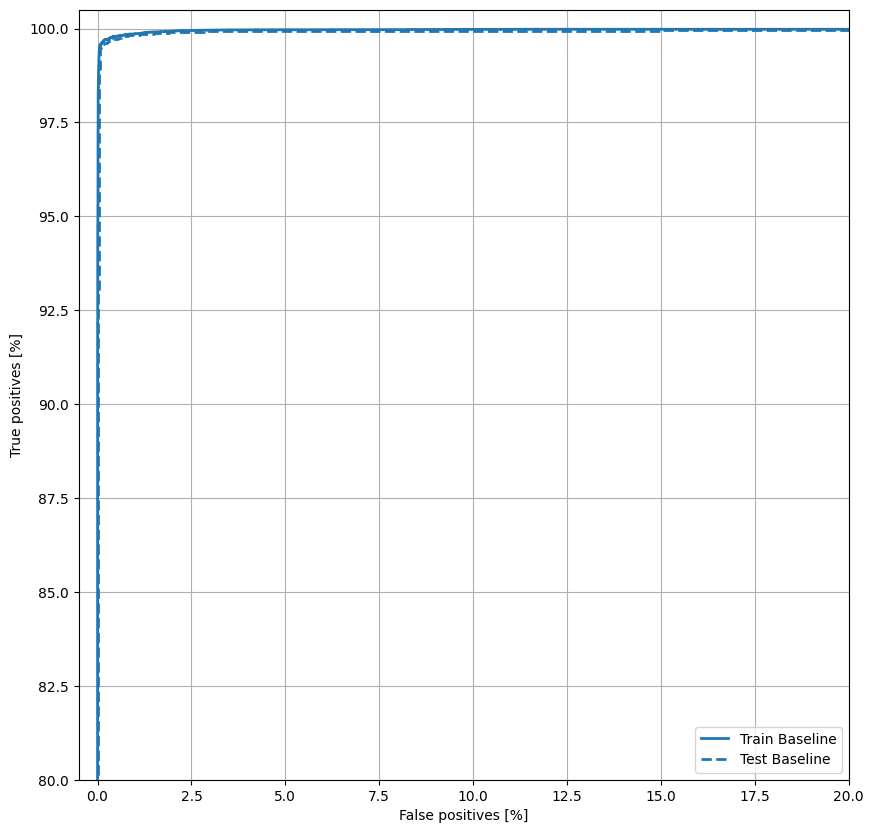

In [48]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

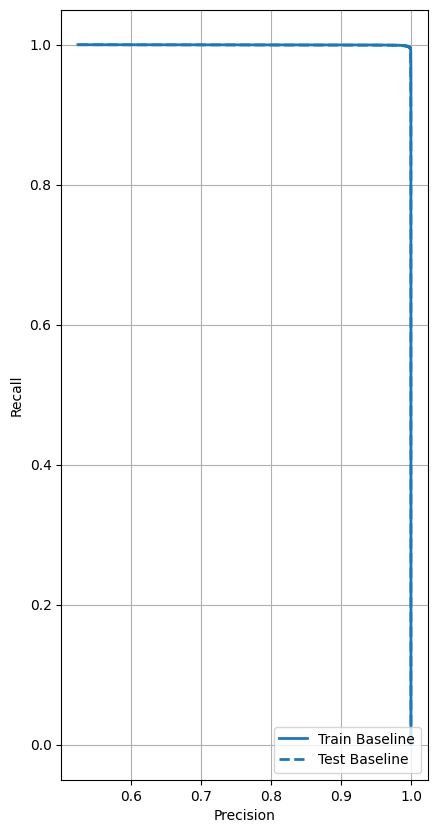

In [49]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [50]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.05
Weight for class 1: 0.95


In [52]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100


/Users/serkan/Documents/Paragliding_Flight_Analyses/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8077 - auc: 0.8991 - fn: 8322.5713 - fp: 11173.2861 - loss: 0.6371 - prc: 0.9107 - precision: 0.8020 - recall: 0.8433 - tn: 33032.1602 - tp: 40545.3750 - val_accuracy: 0.8361 - val_auc: 0.9165 - val_fn: 2019.0000 - val_fp: 2543.0000 - val_loss: 0.4781 - val_prc: 0.9212 - val_precision: 0.8315 - val_recall: 0.8614 - val_tn: 10718.0000 - val_tp: 12551.0000
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7735 - auc: 0.8546 - fn: 5649.4287 - fp: 7159.5356 - loss: 0.5002 - prc: 0.8628 - precision: 0.7717 - recall: 0.8094 - tn: 20489.8027 - tp: 24985.6250 - val_accuracy: 0.8878 - val_auc: 0.9589 - val_fn: 1452.0000 - val_fp: 1671.0000 - val_loss: 0.3738 - val_prc: 0.9628 - val_precision: 0.8870 - val_recall: 0.9003 - val_tn: 11590.0000 - val_tp: 13118.0000
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8368 - auc: 0.9187 - fn: 4418.0181 - fp: 4829.0181 - loss: 0.4036 - prc: 0.9284 - precision: 0.8391 - re

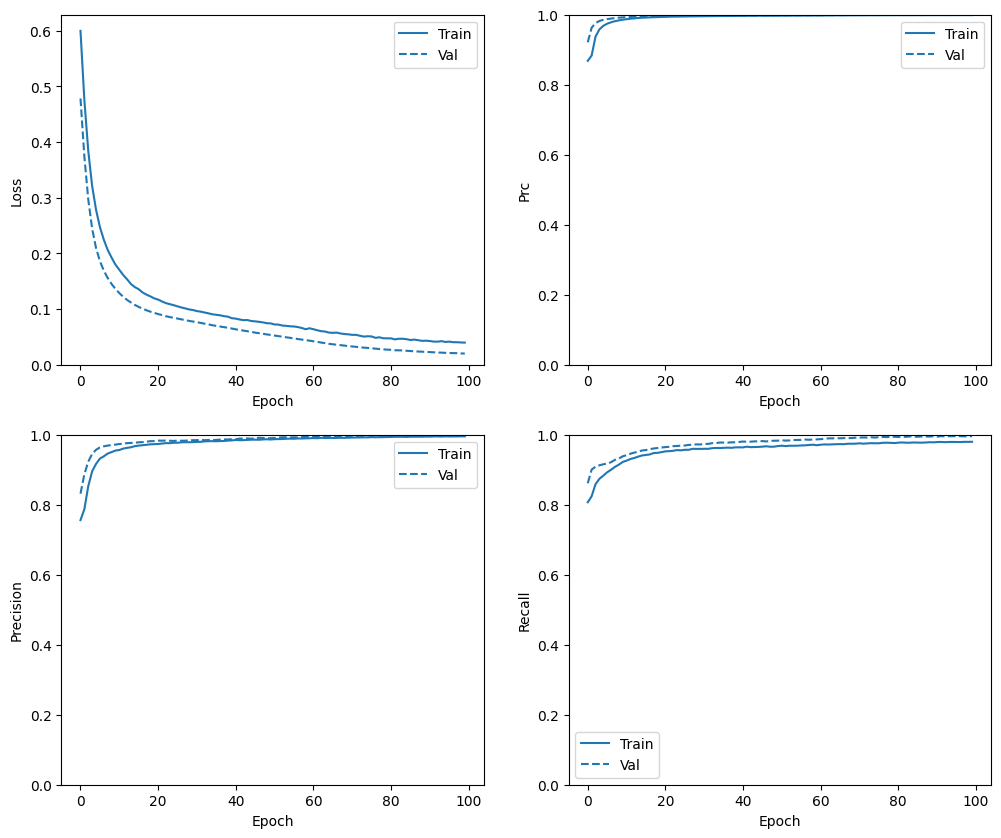

In [53]:
plot_metrics(weighted_history)

In [54]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step


loss :  0.022291991859674454
compile_metrics :  18150.0

Legitimate Transactions Detected (True Negatives):  16524
Legitimate Transactions Incorrectly Detected (False Positives):  24
Fraudulent Transactions Missed (False Negatives):  91
Fraudulent Transactions Detected (True Positives):  18150
Total Fraudulent Transactions:  18241


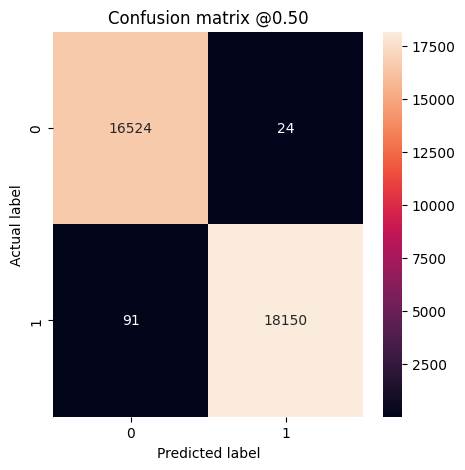

In [55]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

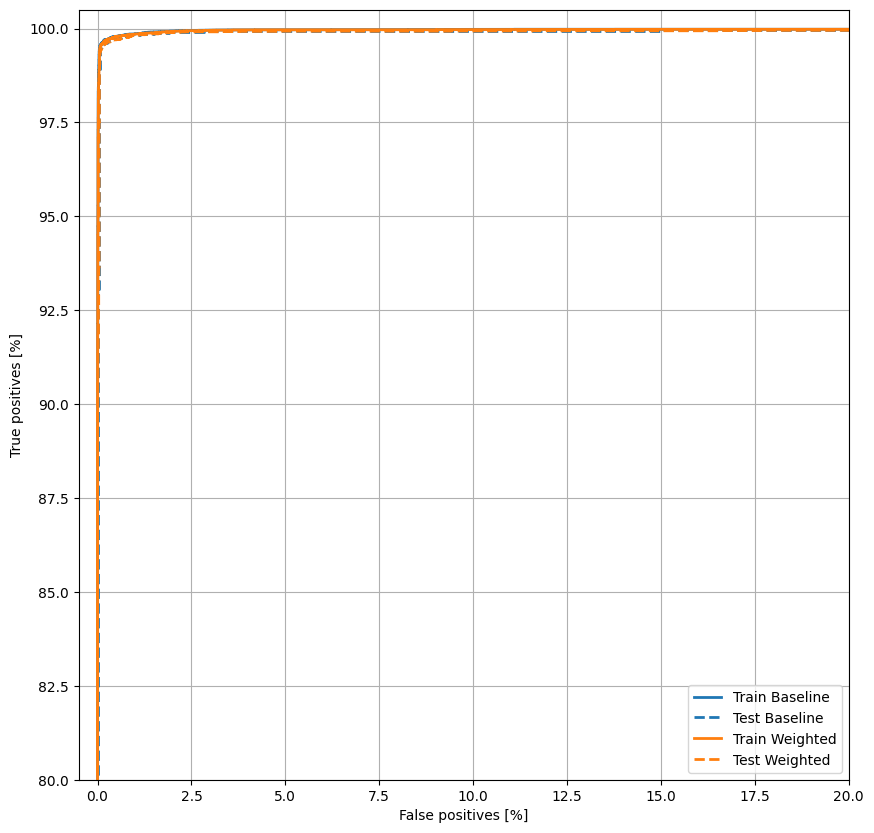

In [56]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

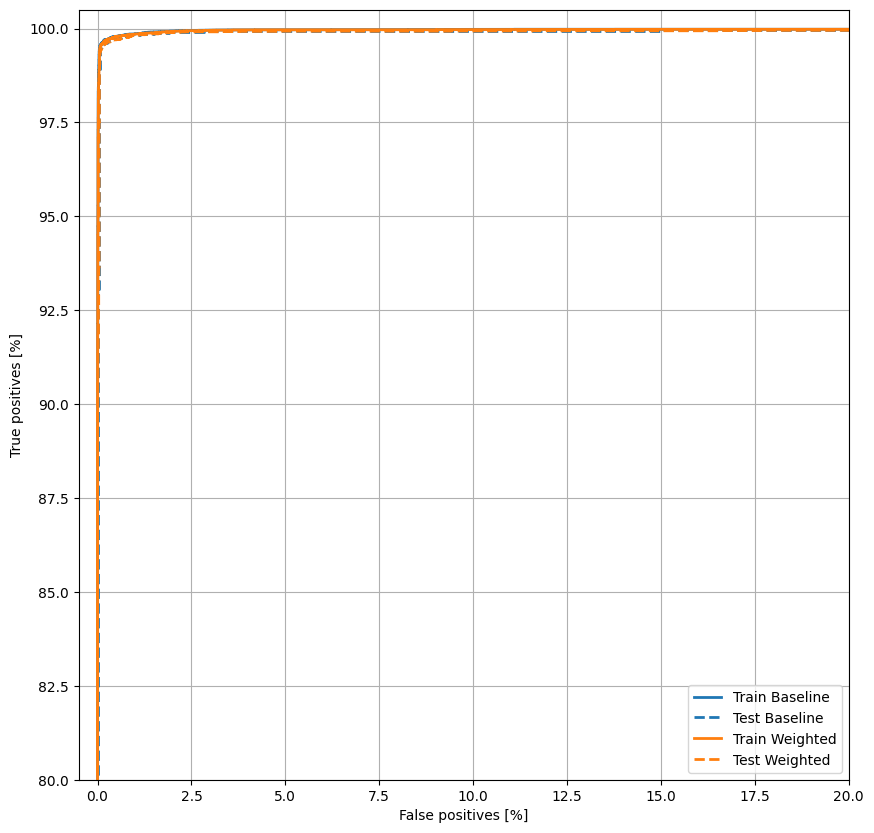

In [57]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

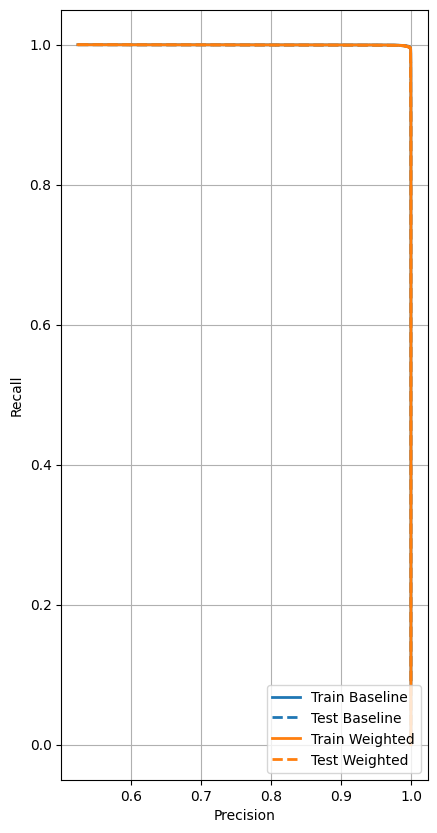

In [58]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

In [60]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(52961, 15)

In [61]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(105922, 15)

In [63]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-0.40069647 -0.03064393  0.4030414   0.08282327  0.54971632  0.28721662
 -0.36978561  0.74422768  1.27393762 -1.60779715 -0.88277853  1.06397026
 -0.03119104  1.19690347 -2.1232018 ]

Label:  1


2025-04-15 20:17:07.054536: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
